In [1]:
from __future__ import print_function
import sys, json, os
import subprocess
import multiprocessing as mp
import numpy as np
from array import array

import pickle
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit

import portROOT2pd
import filepath

SMALL_SIZE = 12
MEDIUM_SIZE = 14 
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers = ['v', 'o', 's', '^', 'P', 'X', 'd', '*', '8', '<', '>']

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
plot_dir = os.path.join(topdir,"paper_plots")

Welcome to JupyROOT 6.28/10


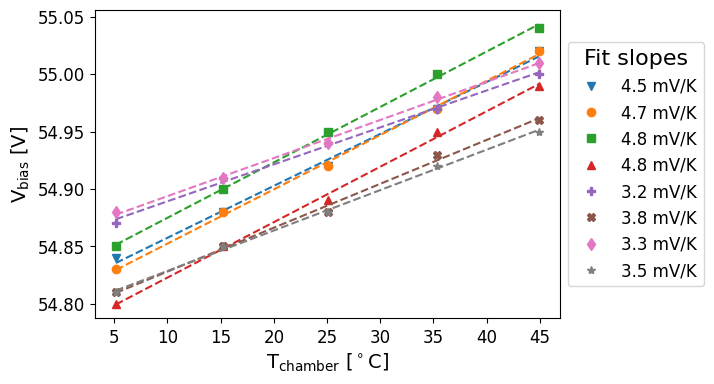

In [2]:
def lin_func(x, a, b):
    return a * x + b

FEB_temp = np.array([5.16, 15.25, 25.13, 35.34, 44.90])
Vpp = np.array([[54.84, 54.83, 54.85, 54.80, 54.87, 54.81, 54.88, 54.81],
                [54.88, 54.88, 54.90, 54.85, 54.91, 54.85, 54.91, 54.85],
                [54.92, 54.92, 54.95, 54.89, 54.94, 54.88, 54.94, 54.88],
                [54.97, 54.97, 55.00, 54.95, 54.97, 54.93, 54.98, 54.92],
                [55.02, 55.02, 55.04, 54.99, 55.00, 54.96, 55.01, 54.95]])
slope_list = []

fig, ax = plt.subplots(figsize = (6,4))
for i in range(8):
    popt_lin, pcov = curve_fit(lin_func, FEB_temp, Vpp[:,i])
    #this = ax.plot(FEB_temp, Vpp[:,i], markers[i], label="ch%i, %.1f mV/K"%(i, popt_lin[0]*1000.))
    this = ax.plot(FEB_temp, Vpp[:,i], markers[i], label="%.1f mV/K"%(popt_lin[0]*1000.))
    slope_list.append(popt_lin[0]*1000.)
    ax.plot(FEB_temp, lin_func(FEB_temp, popt_lin[0], popt_lin[1]), '--', color = this[0].get_color())
plt.legend(title = 'Fit slopes', loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title('V$_{\mathrm{bias}}$ at different FEB temperature')
plt.xlabel('T$_{\mathrm{chamber}}$ [$^\circ\mathrm{C}$]')    
plt.ylabel('V$_{\mathrm{bias}}$ [V]')

plt.show()
fig.savefig(os.path.join(plot_dir,"FEB_bias_temp_impact.pdf"), bbox_inches='tight')

In [3]:
fileList = filepath.getfilelist(["SiDetFEBScan"],"recoROOT",4)[0]
df = portROOT2pd.PortToDF(fileList)

channel 24
0       16.786
1    36.853996
2    46.857777
Name: FEBtemp, dtype: object
0    465.701996
1    446.994995
2    436.381989
Name: calibAdj, dtype: float32
channel 25
0       16.786
1    36.853996
2    46.857777
Name: FEBtemp, dtype: object
0    468.149994
1    448.921997
2    438.079010
Name: calibAdj, dtype: float32
channel 26
0       16.786
1    36.853996
2    46.857777
Name: FEBtemp, dtype: object
0    458.309998
1    439.661011
2    428.825012
Name: calibAdj, dtype: float32
channel 27
0       16.786
1    36.853996
2    46.857777
Name: FEBtemp, dtype: object
0    455.184998
1    438.851013
2    427.595001
Name: calibAdj, dtype: float32


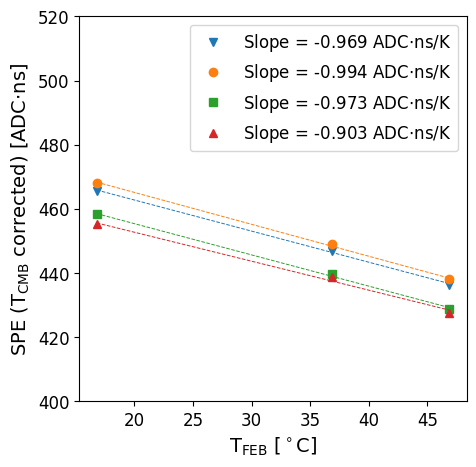

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{FEB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('SPE (T$_{\mathrm{CMB}}$ corrected) [ADC$\cdot$ns]')
channel_start = 24
for chan in range(4):
    df_ = df.query("FEB==0 & ch==%i"%(channel_start+chan)).reset_index()
    x = df_['FEBtemp']
    y = df_['calibAdj']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]
    print("channel", chan+channel_start)
    print(x)
    print(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
         
    #scatter = ax.plot(x, y, markers[chan], label='Chan: %d, slope = %.3f ADC$\cdot$ns,  intercept = %.3f'%(chan+channel_start, slope, intercept))
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.3f ADC$\cdot$ns/K'%(chan+channel_start, slope))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.3f ADC$\cdot$ns/K'%(slope))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([400, 520])
    ax.legend()

plt.show()
fig.savefig(os.path.join(plot_dir,"SPE_corr_FEB_temp.pdf"), bbox_inches='tight')

In [5]:
fileList = filepath.getfilelist(["SiDet1CMBScan"],"recoROOT",4)[0]
additional_dict = {'VoverN'    :filepath.datatag["SiDet1CMBScan"]["VoverN"],
                   'VppN'      :filepath.datatag["SiDet1CMBScan"]["VppN"],
                   'tempSetup' :filepath.datatag["SiDet1CMBScan"]["tempSetup"],
                   'tempSensor':filepath.datatag["SiDet1CMBScan"]["tempSensor"]}
df = portROOT2pd.PortToDF(fileList, additional_dict, True)
pkl004name = os.path.join(analysis_dir,"tempScanSiDetRun1_004.pkl")

with open(pkl004name, 'wb') as f:
    pickle.dump(df, f)

Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/92/ed/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001434_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/21/f3/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001433_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/44/c0/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001435_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/7e/77/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001436_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/ed/9b/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001437_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-004-000/root/96/e0/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.001438_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-00

In [6]:
pklname = os.path.join(analysis_dir,"tempScanSiDetRun1_004.pkl")
# pklname = os.path.join(analysis_dir,"tempScanSiDetRun1.pkl")

with open(pklname, 'rb') as f:
    df = pickle.load(f)

# remove runs with Vover < 2V 
df = df.query("VoverN > 1.5").reset_index() 

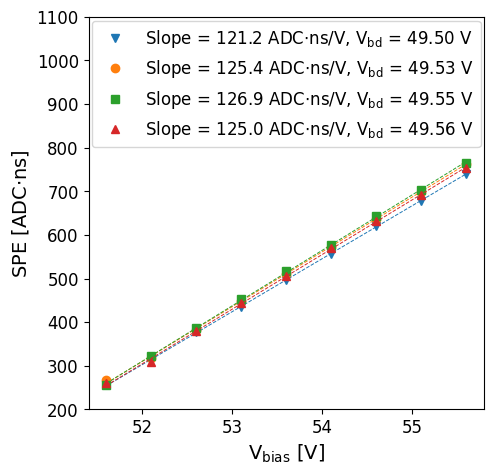

In [7]:
fig, ax = plt.subplots(figsize=(5.1, 5.1))
ax.set_xlabel('V$_{\mathrm{bias}}$ [V]')
ax.set_ylabel('SPE [ADC$\cdot$ns]')
channel_start = 0
for chan in range(4):
    df_ = df.query("FEB==0 & ch==%i & tempSetup==-10.0"%(channel_start+chan)).reset_index()
    x = df_['VppN']
    y = df_['calibRaw']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]
    # print("channel", chan+channel_start)
    # print(x)
    # print(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    vbd = -intercept/slope
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.1f ADC$\cdot$ns/V, Vbd = %.2f V'%(chan+channel_start, slope, vbd))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.1f ADC$\cdot$ns/V, V$_{\mathrm{bd}}$ = %.2f V'%(slope, vbd))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([200, 1100])
    # ax.set_xlim([51.2, 58.8])
   
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01))
plt.show()
fig.savefig(os.path.join(plot_dir,"SPE_bias_scan_m10C_raw.pdf"), bbox_inches='tight')

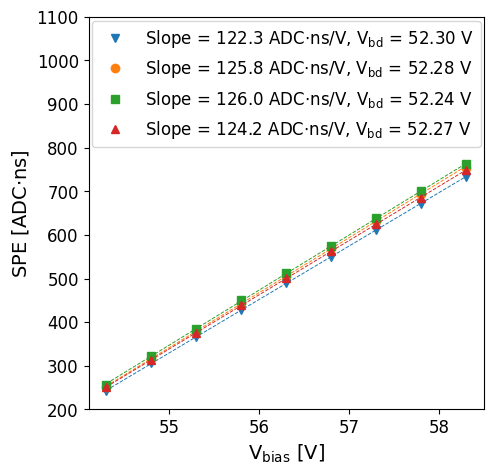

In [8]:
fig, ax = plt.subplots(figsize=(5.1, 5.1))
ax.set_xlabel('V$_{\mathrm{bias}}$ [V]')
ax.set_ylabel('SPE [ADC$\cdot$ns]')
channel_start = 0
for chan in range(4):
    df_ = df.query("FEB==0 & ch==%i & tempSetup==40.0"%(channel_start+chan)).reset_index()
    x = df_['VppN']
    y = df_['calibRaw']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]
    # print("channel", chan+channel_start)
    # print(x)
    # print(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    vbd = -intercept/slope
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.1f ADC$\cdot$ns/V, Vbd = %.2f V'%(chan+channel_start, slope, vbd))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.1f ADC$\cdot$ns/V, V$_{\mathrm{bd}}$ = %.2f V'%(slope, vbd))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([200, 1100])
    # ax.set_xlim([51.2, 58.8])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01))
plt.show()
fig.savefig(os.path.join(plot_dir,"SPE_bias_scan_40C_raw.pdf"), bbox_inches='tight')

In [9]:
tempSensors = df['tempSensor'].unique()
tempSensors = np.sort(tempSensors)

bad_channels = [18, 29, 37, 38, 44, 58]

df_SPE = pd.DataFrame(columns=['chan', 'tempSensor', 
                               'SPEperV', 'SPEperV_err', 
                               'intercept', 'intercept_err',
                               'Vbd', 'Vbd_err', 
                               'spe_3V_over', 'spe_54V_fix', 'spe_54V_fix_adj'])

for chan in range(64):
    if chan in bad_channels:
        continue
    for tTemp in tempSensors:
        df_ = df.query("ch==%i & tempSensor==%f"%(chan, tTemp)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['calibRaw'].astype(float)
        zz = df_['calibAdj'].astype(float)
        mask = ~np.isnan(yy)
        mask1 = zz>0
        xx1=xx[mask1]
        xx=xx[mask]
        yy=yy[mask]
        zz=zz[mask1]
        if yy.size==0 :
            print("Bad channel: %d at set temp %.0f C"%(chan, tTemp))
            continue

        popt, pcov = curve_fit(lin_func, xx.astype(float), yy.astype(float))
        slope = popt[0]
        intercept = popt[1]
        std_err = np.sqrt(pcov[0,0])
        intercept_stderr = np.sqrt(pcov[1,1])

        popt1, pcov1 = curve_fit(lin_func, xx1.astype(float), zz.astype(float))
        slope1 = popt1[0]
        intercept1 = popt1[1]
        std_err1 = np.sqrt(pcov1[0,0])
        intercept_stderr1 = np.sqrt(pcov1[1,1])
        if tTemp == 5.3 and chan<4:
            print ('Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept1, slope1, -intercept1/slope1))

        if slope == 0 or intercept == 0:
            print(chan, "slope:", slope, "intercept", intercept, "\n", xx, yy)

        new_row = {'chan':chan, 
                   'tempSensor':tTemp,
                   'SPEperV':slope, 
                   'SPEperV_err':std_err, 
                   'intercept':intercept, 
                   'intercept_err':intercept_stderr,
                   'Vbd':-intercept/slope, 
                   'Vbd_err':(-intercept/slope)*np.sqrt(std_err*std_err/slope/slope+intercept_stderr*intercept_stderr/intercept/intercept),
                   'spe_3V_over':slope*3,
                   'spe_54V_fix':slope*54+intercept,
                   'spe_54V_fix_adj':slope1*54+intercept1}
        df_SPE.loc[len(df_SPE)] = new_row

Chan: 0, SPE = -6229.2+121.7V, Vbd = 51.18
Chan: 1, SPE = -6402.8+125.2V, Vbd = 51.15
Chan: 2, SPE = -6380.8+124.9V, Vbd = 51.10
Chan: 3, SPE = -6384.0+124.7V, Vbd = 51.19


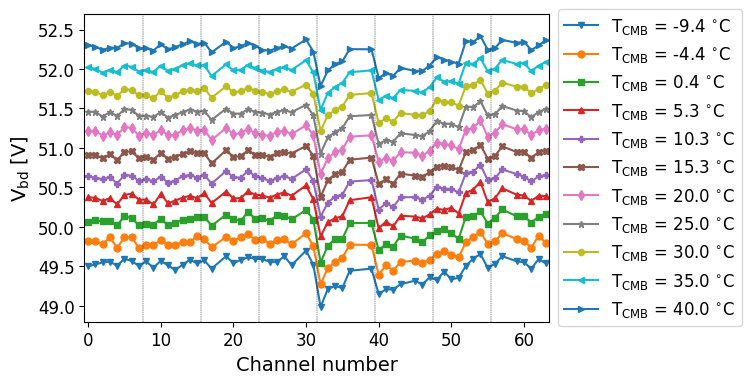

In [10]:
fig = plt.figure(figsize = (6,4))
for i,temp in enumerate(tempSensors):
    df_ = df_SPE.query('tempSensor == %f'%temp)
    plt.plot(df_['chan'], df_['Vbd'],markers[i]+'-', markersize=5,
                 label='T$_{\mathrm{CMB}}$ = %.1f $^{\circ}\mathrm{C}$'%temp)
# plt.title("Breakdown voltages")
plt.xlabel("Channel number")
plt.ylabel("V$_{\mathrm{bd}}$ [V]")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(48.8, 52.7)
plt.show()
fig.savefig(os.path.join(plot_dir,"Vbd_by-channel.pdf"), bbox_inches='tight')

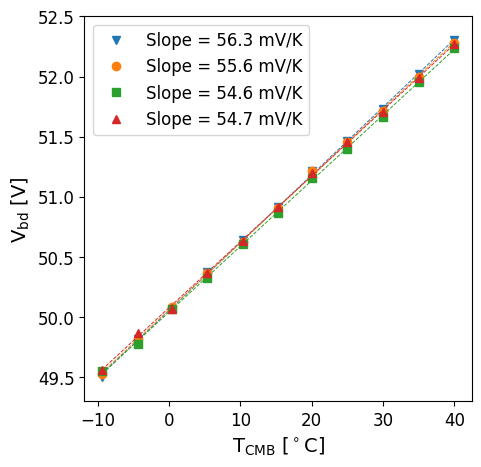

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('V$_{\mathrm{bd}}$ [V]')
for chan in range(4):
    x = df_SPE.query('chan==%d'%chan)['tempSensor'].astype(float)
    y = df_SPE.query('chan==%d'%chan)['Vbd'].astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.1f mV/K'%(chan, slope*1000))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.1f mV/K'%(slope*1000))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([49.3, 52.5])
    ax.legend()
fig.savefig(os.path.join(plot_dir,"Vbd_temp.pdf"), bbox_inches='tight')

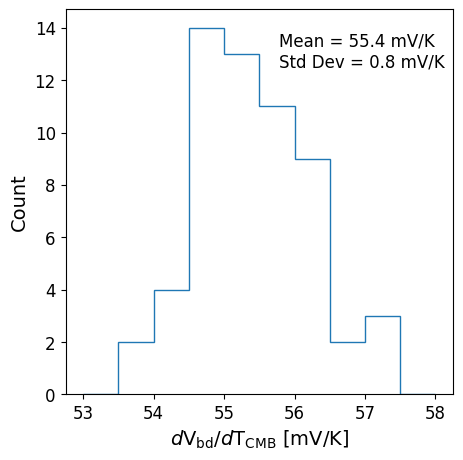

In [12]:
VbdPerK = []

for chan in range(64):
    if chan in bad_channels:
        continue
    x = df_SPE.query('chan==%d'%chan)['tempSensor'].astype(float)
    y = df_SPE.query('chan==%d'%chan)['Vbd'].astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    VbdPerK.append(slope*1000)
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(VbdPerK, bins=[53+0.5*i for i in range(11)], histtype='step')
# ax.set_title('mean = %.1f $\pm$  mV/K'%(np.mean(VbdPerK))+', $\sigma$ = %.1f mV/K'%(np.std(VbdPerK)))
ax.text(0.55, 0.85, 'Mean = %.1f mV/K'%(np.mean(VbdPerK))+'\n'+'Std Dev = %.1f mV/K'%(np.std(VbdPerK)), fontsize = 12, transform=ax.transAxes)
ax.set_xlabel('$d$V$_{\mathrm{bd}}$/$d$T$_{\mathrm{CMB}}$ [mV/K]')
ax.set_ylabel('Count')
fig.savefig(os.path.join(plot_dir,"Vbd_slope.pdf"), bbox_inches='tight')

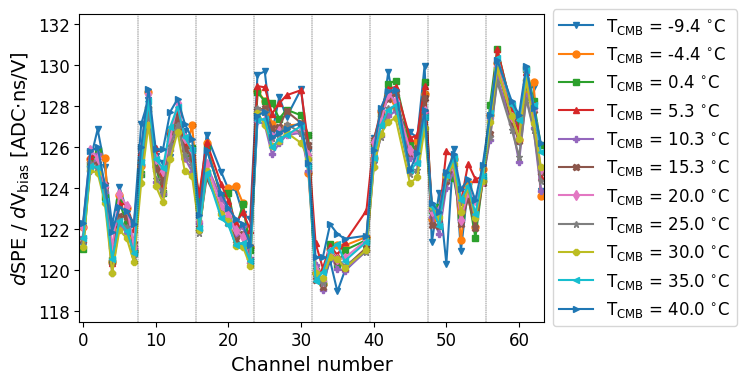

125.22734934512553 2.5039656972919127


In [13]:
fig = plt.figure(figsize = (6,4))
for i,temp in enumerate(tempSensors):
    df_ = df_SPE.query('tempSensor == %f'%temp)
    plt.plot(df_['chan'], df_['SPEperV'],markers[i]+'-', markersize=5, #yerr = df_['SPEperV_err'],
             label='T$_{\mathrm{CMB}}$ = %.1f $^{\circ}\mathrm{C}$'%temp)
# plt.title("$d$SPE / $d$V$_{\mathrm{bias}}$ of each channel")
plt.xlabel("Channel number")
plt.ylabel("$d$SPE / $d$V$_{\mathrm{bias}}$ [ADC$\cdot$ns/V]")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(117.5, 132.5)
plt.show()
fig.savefig(os.path.join(plot_dir,"SPEperV.pdf"), bbox_inches='tight')

print(np.mean(df_['SPEperV']), np.std(df_['SPEperV']))

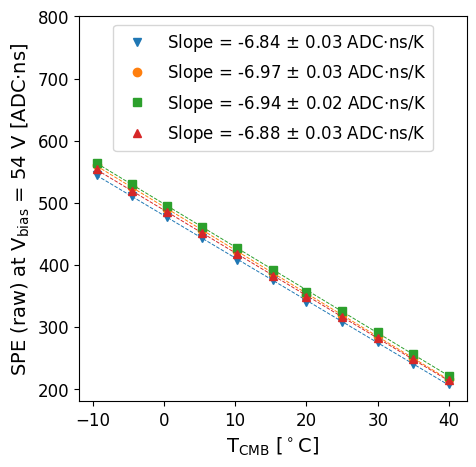

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('SPE (raw) at V$_{\mathrm{bias}}$ = 54 V [ADC$\cdot$ns]')
for chan in range(4):
    df_ = df_SPE.query("chan==%i"%(chan)).reset_index()
    x = df_['tempSensor']
    y = df_['spe_54V_fix']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(chan+channel_start, slope, std_err))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.2f $\pm$ %.2f ADC$\cdot$ns/K'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([180, 800])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

fig.savefig(os.path.join(plot_dir,"SPE_vs_temp.pdf"), bbox_inches='tight')

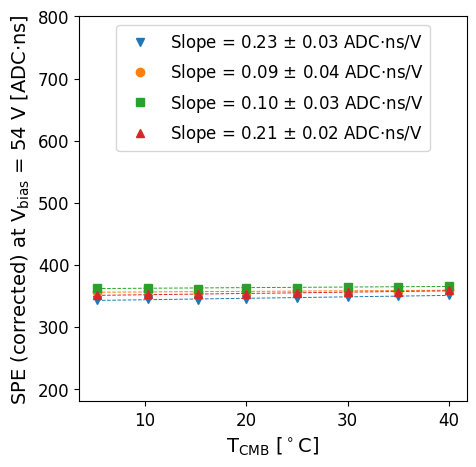

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('SPE (corrected) at V$_{\mathrm{bias}}$ = 54 V [ADC$\cdot$ns]')
for chan in range(4):
    df_ = df_SPE.query("chan==%i & tempSensor > 1"%(chan)).reset_index()
    x = df_['tempSensor']
    y = df_['spe_54V_fix_adj']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(chan+channel_start, slope, std_err))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([180, 800])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

fig.savefig(os.path.join(plot_dir,"SPEcorr_vs_temp.pdf"), bbox_inches='tight')

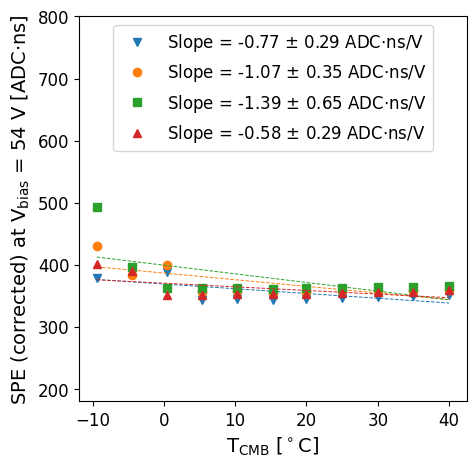

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('SPE (corrected) at V$_{\mathrm{bias}}$ = 54 V [ADC$\cdot$ns]')
for chan in range(4):
    df_ = df_SPE.query("chan==%i"%(chan)).reset_index()
    x = df_['tempSensor']
    y = df_['spe_54V_fix_adj']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(chan+channel_start, slope, std_err))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([180, 800])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

In [17]:
fileList = filepath.getfilelist(["SiDet1CMBScan"],"recoROOT",8)[0]
additional_dict = {'VoverN'    :filepath.datatag["SiDet1CMBScan"]["VoverN"],
                   'VppN'      :filepath.datatag["SiDet1CMBScan"]["VppN"],
                   'tempSetup' :filepath.datatag["SiDet1CMBScan"]["tempSetup"],
                   'tempSensor':filepath.datatag["SiDet1CMBScan"]["tempSensor"]}
df_008 = portROOT2pd.PortToDF(fileList, additional_dict, True)
# remove runs with Vover < 2V 
df_008 = df_008.query("VoverN > 1.5").reset_index()

df_008_SPE = pd.DataFrame(columns=['chan', 'tempSensor', 
                               'SPEperV', 'SPEperV_err', 
                               'intercept', 'intercept_err',
                               'Vbd', 'Vbd_err', 
                               'spe_3V_over', 'spe_54V_fix', 'spe_54V_fix_adj'])

for chan in range(64):
    if chan in bad_channels:
        continue
    for tTemp in tempSensors:
        df_ = df_008.query("ch==%i & tempSensor==%f"%(chan, tTemp)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['calibRaw'].astype(float)
        zz = df_['calibAdj'].astype(float)
        mask = ~np.isnan(yy)
        mask1 = zz>0
        xx1=xx[mask1]
        xx=xx[mask]
        yy=yy[mask]
        zz=zz[mask1]
        if yy.size==0 :
            print("Bad channel: %d at set temp %.0f C"%(chan, tTemp))
            continue

        popt, pcov = curve_fit(lin_func, xx.astype(float), yy.astype(float))
        slope = popt[0]
        intercept = popt[1]
        std_err = np.sqrt(pcov[0,0])
        intercept_stderr = np.sqrt(pcov[1,1])

        popt1, pcov1 = curve_fit(lin_func, xx1.astype(float), zz.astype(float))
        slope1 = popt1[0]
        intercept1 = popt1[1]
        std_err1 = np.sqrt(pcov1[0,0])
        intercept_stderr1 = np.sqrt(pcov1[1,1])
        if tTemp == 5.3 and chan<4:
            print ('Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept1, slope1, -intercept1/slope1))

        if slope == 0 or intercept == 0:
            print(chan, "slope:", slope, "intercept", intercept, "\n", xx, yy)

        new_row = {'chan':chan, 
                   'tempSensor':tTemp,
                   'SPEperV':slope, 
                   'SPEperV_err':std_err, 
                   'intercept':intercept, 
                   'intercept_err':intercept_stderr,
                   'Vbd':-intercept/slope, 
                   'Vbd_err':(-intercept/slope)*np.sqrt(std_err*std_err/slope/slope+intercept_stderr*intercept_stderr/intercept/intercept),
                   'spe_3V_over':slope*3,
                   'spe_54V_fix':slope*54+intercept,
                   'spe_54V_fix_adj':slope1*54+intercept1}
        df_008_SPE.loc[len(df_008_SPE)] = new_row

Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/41/82/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001434_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/20/11/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001433_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/d3/e7/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001435_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/fd/8d/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001436_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/33/0f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001437_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/59/e5/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001438_000.root
Opening /pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-00

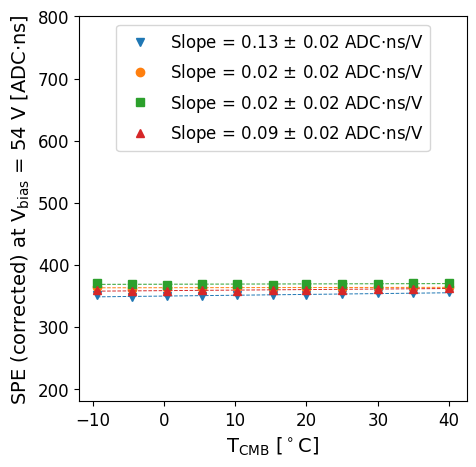

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('SPE (corrected) at V$_{\mathrm{bias}}$ = 54 V [ADC$\cdot$ns]')
for chan in range(4):
    df_ = df_008_SPE.query("chan==%i"%(chan)).reset_index()
    x = df_['tempSensor']
    y = df_['spe_54V_fix_adj']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    # scatter = ax.plot(x, y, markers[chan], label='Chan %d, slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(chan+channel_start, slope, std_err))
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.2f $\pm$ %.2f ADC$\cdot$ns/V'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([180, 800])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

fig.savefig(os.path.join(plot_dir,"SPEcorr_vs_temp_008.pdf"), bbox_inches='tight')

Suggest to replace with the 008 plot. The 004 one had issue with negative temperature and the correctred SPE for those temperatures were all wrong and omitted. Better replace with this one to show the correction works for the whole temperature range tested. 

Chan: 48, PE = -396.8+8.0V
Chan: 49, PE = -410.8+8.3V
Chan: 50, PE = -395.9+8.0V
Chan: 51, PE = -391.1+7.9V


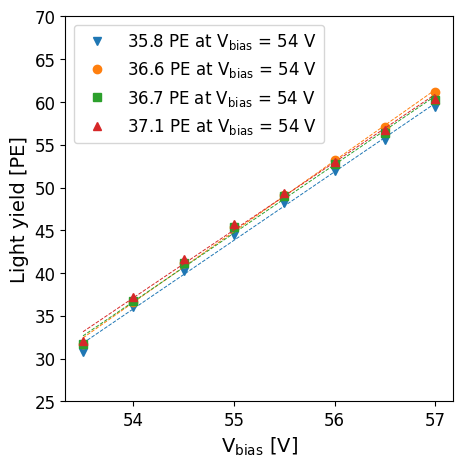

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('V$_{\mathrm{bias}}$ [V]')
ax.set_ylabel('Light yield [PE]')
channel_start = 48
for chan in range(4):
    df_ = df.query("FEB==0 & ch==%i & tempSensor==25.0"%(channel_start+chan)).reset_index()
    x = df_['VppN']
    y = df_['PEs']
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]
    # print("channel", chan+channel_start)
    # print(x)
    # print(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    vbd = -intercept/slope
    PE_54V = slope*54+intercept
    
    # scatter = ax.plot(x, y, markers[chan], label='Slope = %.1f PE/V, %.1f PE @ V$_{\mathrm{bias}}$ = 54 V'%(slope, PE_54V))
    scatter = ax.plot(x, y, markers[chan], label='%.1f PE at V$_{\mathrm{bias}}$ = 54 V'%(PE_54V))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([25, 70])

    print ('Chan: %d, PE = %.1f+%.1fV'%(channel_start+chan, intercept, slope))
 
plt.legend()
plt.show()
fig.savefig(os.path.join(plot_dir,"PE_vs_bias.pdf"), bbox_inches='tight')

In [20]:
df_PE = pd.DataFrame(columns=['chan', 'tempSensor', 
                              'pe_54V_fix', 'pe_54V_fix_adj'])

for chan in range(64):
    if chan in bad_channels:
        continue
    for tTemp in tempSensors:
        df_ = df.query("ch==%i & tempSensor==%f"%(chan, tTemp)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)
        zz = df_['PEsCorrected'].astype(float)
        mask = ~np.isnan(yy) & (yy!=0)        
        mask1 = zz>0
        xx1=xx[mask1]
        xx=xx[mask]
        yy=yy[mask]
        zz=zz[mask1]
        if yy.size==0 :
            print("Bad channel: %d at set temp %.0f C"%(chan, tTemp))
            continue

        popt, pcov = curve_fit(lin_func, xx.astype(float), yy.astype(float))
        slope = popt[0]
        intercept = popt[1]
        std_err = np.sqrt(pcov[0,0])
        intercept_stderr = np.sqrt(pcov[1,1])
        if tTemp == 25 and chan>=48 and chan<56:
            #print (xx.to_numpy())
            #print (yy.to_numpy())
            print ('Chan: %d, PE = %.1f+%.1fV'%(chan, intercept, slope))

        popt1, pcov1 = curve_fit(lin_func, xx1.astype(float), zz.astype(float))
        slope1 = popt1[0]
        intercept1 = popt1[1]
        std_err1 = np.sqrt(pcov1[0,0])
        intercept_stderr1 = np.sqrt(pcov1[1,1])
        if tTemp == 25 and chan>=48 and chan<56:
            #print (xx1.to_numpy())
            #print (zz.to_numpy())
            print ('Chan: %d, PE = %.1f+%.1fV'%(chan, intercept1, slope1))

        if slope == 0 or intercept == 0:
            print(chan, "slope:", slope, "intercept", intercept, "\n", xx, yy)

        new_row = {'chan':chan, 
                   'tempSensor':tTemp,
                   'pe_54V_fix': 54*slope+intercept,
                   'pe_54V_fix_adj': 54*slope1+intercept1}
        df_PE.loc[len(df_PE)] = new_row

Chan: 48, PE = -396.8+8.0V
Chan: 48, PE = -428.8+8.7V
Chan: 49, PE = -410.8+8.3V
Chan: 49, PE = -440.9+8.9V
Chan: 50, PE = -395.9+8.0V
Chan: 50, PE = -427.3+8.6V
Chan: 51, PE = -391.1+7.9V
Chan: 51, PE = -422.3+8.6V
Chan: 52, PE = -399.9+8.0V
Chan: 52, PE = -435.5+8.7V
Chan: 53, PE = -381.5+7.7V
Chan: 53, PE = -411.4+8.3V
Chan: 54, PE = -387.0+7.8V
Chan: 54, PE = -418.8+8.4V
Chan: 55, PE = -369.0+7.5V
Chan: 55, PE = -396.8+8.0V


In [21]:
start_chan = 48
for chan in range(4):
    df_ = df_PE.query("chan==%i"%(chan+start_chan)).reset_index()
    display(df_)

,index,chan,tempSensor,pe_54V_fix,pe_54V_fix_adj
0,473,48,-9.4,50.461717,36.208912
1,474,48,-4.4,48.617154,37.164641
2,475,48,0.4,46.469687,37.292995
3,476,48,5.3,44.394418,37.513538
4,477,48,10.3,42.325224,37.862986
5,478,48,15.3,40.113758,38.038350
6,479,48,20.0,38.165082,38.556040
7,480,48,25.0,35.821159,38.532748
8,481,48,30.0,33.812728,39.112192
9,482,48,35.0,31.695590,39.524862


,index,chan,tempSensor,pe_54V_fix,pe_54V_fix_adj
0,484,49,-9.4,53.764965,38.386130
1,485,49,-4.4,51.779823,39.562589
2,486,49,0.4,49.417751,39.723703
3,487,49,5.3,47.147862,40.037086
4,488,49,10.3,44.631199,39.887318
5,489,49,15.3,42.360967,40.180870
6,490,49,20.0,40.102578,40.444040
7,491,49,25.0,36.572569,39.423665
8,492,49,30.0,34.673414,40.053718
9,493,49,35.0,32.617382,40.702565


,index,chan,tempSensor,pe_54V_fix,pe_54V_fix_adj
0,495,50,-9.4,52.392938,36.276106
1,496,50,-4.4,50.515080,37.525621
2,497,50,0.4,48.384338,38.842243
3,498,50,5.3,46.370764,39.426759
4,499,50,10.3,44.192624,39.504853
5,500,50,15.3,42.115339,39.937217
6,501,50,20.0,39.469384,39.818859
7,502,50,25.0,36.664925,39.444617
8,503,50,30.0,34.799872,40.268891
9,504,50,35.0,32.609109,40.680703


,index,chan,tempSensor,pe_54V_fix,pe_54V_fix_adj
0,506,51,-9.4,52.381349,38.213194
1,507,51,-4.4,50.365466,38.451257
2,508,51,0.4,48.160165,38.591960
3,509,51,5.3,46.240305,39.093580
4,510,51,10.3,44.239391,39.597473
5,511,51,15.3,42.167856,40.002491
6,512,51,20.0,39.724382,40.102782
7,513,51,25.0,37.110441,39.921781
8,514,51,30.0,35.133115,40.684193
9,515,51,35.0,33.036396,41.274714


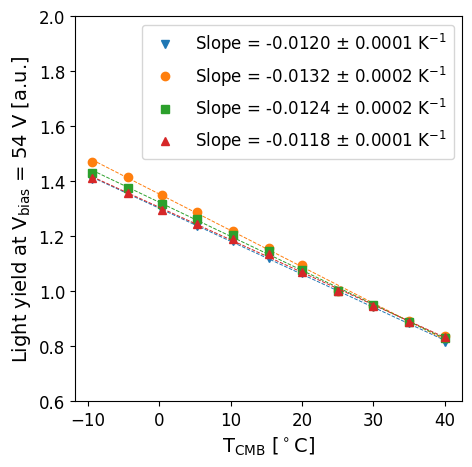

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('Light yield at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
start_chan = 48
for chan in range(4):
    df_ = df_PE.query("chan==%i"%(chan+start_chan)).reset_index()
    x = df_['tempSensor']
    y = df_['pe_54V_fix'].to_numpy()
    y = y/y[7]
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.4f $\pm$ %.4f K$^{-1}$'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([0.6, 2])
    ax.legend()

fig.savefig(os.path.join(plot_dir,"PE_vs_temp_54V.pdf"), bbox_inches='tight')

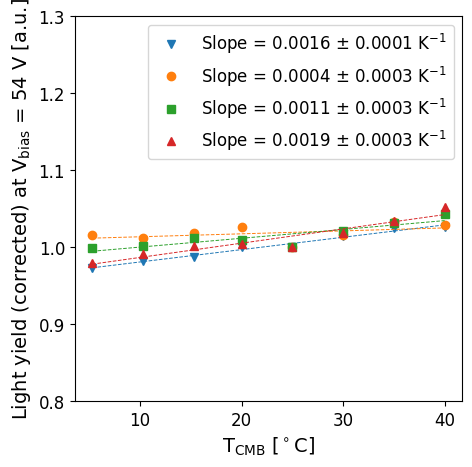

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('Light yield (corrected) at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
start_chan = 48
for chan in range(4):
    df_ = df_PE.query("chan==%i & tempSensor > 1"%(chan+start_chan)).reset_index()
    x = df_['tempSensor']
    y = df_['pe_54V_fix_adj'].to_numpy()
    y = y/y[4]
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.4f $\pm$ %.4f K$^{-1}$'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([0.8, 1.3])
    ax.legend()

fig.savefig(os.path.join(plot_dir,"PE_corr_vs_temp.pdf"), bbox_inches='tight')

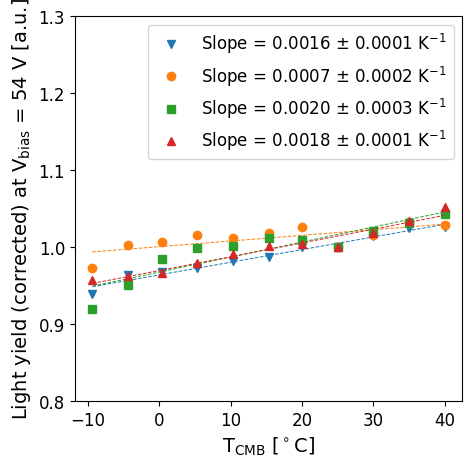

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('Light yield (corrected) at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
start_chan = 48
for chan in range(4):
    df_ = df_PE.query("chan==%i"%(chan+start_chan)).reset_index()
    x = df_['tempSensor']
    y = df_['pe_54V_fix_adj'].to_numpy()
    y = y/y[7]
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.4f $\pm$ %.4f K$^{-1}$'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([0.8, 1.3])
    ax.legend()


In [25]:
df_008_PE = pd.DataFrame(columns=['chan', 'tempSensor', 
                              'pe_54V_fix', 'pe_54V_fix_adj'])

for chan in range(64):
    if chan in bad_channels:
        continue
    for tTemp in tempSensors:
        df_ = df_008.query("ch==%i & tempSensor==%f"%(chan, tTemp)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)
        zz = df_['PEsCorrected'].astype(float)
        mask = ~np.isnan(yy) & (yy>1)        
        mask1 = zz>1
        xx1=xx[mask1]
        xx=xx[mask]
        yy=yy[mask]
        zz=zz[mask1]
        if yy.size==0 :
            print("Bad channel: %d at set temp %.0f C"%(chan, tTemp))
            continue

        popt, pcov = curve_fit(lin_func, xx.astype(float), yy.astype(float))
        slope = popt[0]
        intercept = popt[1]
        std_err = np.sqrt(pcov[0,0])
        intercept_stderr = np.sqrt(pcov[1,1])
        if tTemp == 25 and chan>=48 and chan<56:
            #print (xx.to_numpy())
            #print (yy.to_numpy())
            print ('Chan: %d, PE = %.1f+%.1fV'%(chan, intercept, slope))

        popt1, pcov1 = curve_fit(lin_func, xx1.astype(float), zz.astype(float))
        slope1 = popt1[0]
        intercept1 = popt1[1]
        std_err1 = np.sqrt(pcov1[0,0])
        intercept_stderr1 = np.sqrt(pcov1[1,1])
        if tTemp == 25 and chan>=48 and chan<56:
            #print (xx1.to_numpy())
            #print (zz.to_numpy())
            print ('Chan: %d, PE = %.1f+%.1fV'%(chan, intercept1, slope1))

        if slope == 0 or intercept == 0:
            print(chan, "slope:", slope, "intercept", intercept, "\n", xx, yy)

        new_row = {'chan':chan, 
                   'tempSensor':tTemp,
                   'pe_54V_fix': 54*slope+intercept,
                   'pe_54V_fix_adj': 54*slope1+intercept1}
        df_008_PE.loc[len(df_008_PE)] = new_row

Chan: 48, PE = -396.9+8.0V
Chan: 48, PE = -423.3+8.5V
Chan: 49, PE = -410.7+8.3V
Chan: 49, PE = -439.6+8.9V
Chan: 50, PE = -395.7+8.0V
Chan: 50, PE = -421.0+8.5V
Chan: 51, PE = -391.3+7.9V
Chan: 51, PE = -417.8+8.5V
Chan: 52, PE = -399.4+8.0V
Chan: 52, PE = -430.6+8.6V
Chan: 53, PE = -380.5+7.6V
Chan: 53, PE = -406.7+8.2V
Chan: 54, PE = -387.0+7.8V
Chan: 54, PE = -413.2+8.3V
Chan: 55, PE = -368.8+7.5V
Chan: 55, PE = -392.9+7.9V


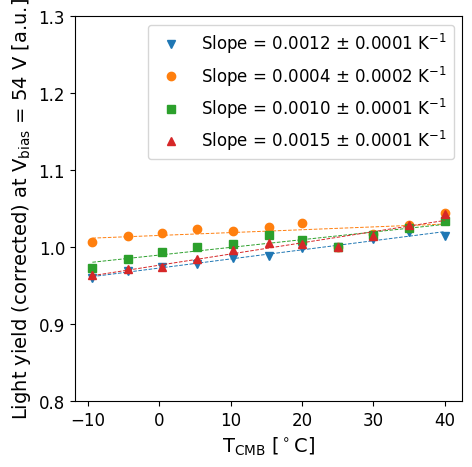

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('Light yield (corrected) at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
start_chan = 48
for chan in range(4):
    df_ = df_008_PE.query("chan==%i"%(chan+start_chan)).reset_index()
    x = df_['tempSensor']
    y = df_['pe_54V_fix_adj'].to_numpy()
    y = y/y[7]
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.4f $\pm$ %.4f K$^{-1}$'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([0.8, 1.3])
    ax.legend()
    
fig.savefig(os.path.join(plot_dir,"PE_corr_vs_temp_008.pdf"), bbox_inches='tight')

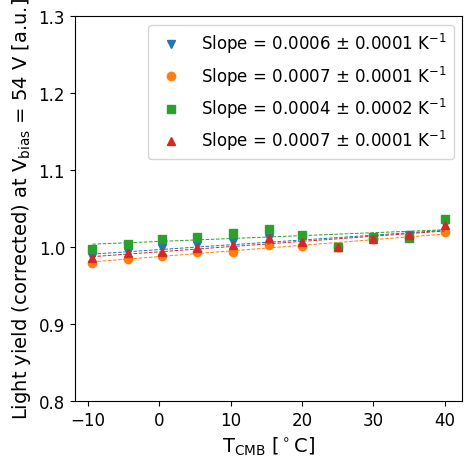

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
ax.set_ylabel('Light yield (corrected) at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
start_chan = 20
for chan in range(4):
    df_ = df_008_PE.query("chan==%i"%(chan+start_chan)).reset_index()
    x = df_['tempSensor']
    y = df_['pe_54V_fix_adj'].to_numpy()
    y = y/y[7]
                
    mask1 = ~np.isnan(y)
    mask2 = (y!=0)
    mask = mask1 & mask2
    x=x[mask]
    y=y[mask]

    popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    
    scatter = ax.plot(x, y, markers[chan], label='Slope = %.4f $\pm$ %.4f K$^{-1}$'%(slope, std_err))
    ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
    ax.set_ylim([0.8, 1.3])
    ax.legend()
    
fig.savefig(os.path.join(plot_dir,"PE_corr_vs_temp_008_alternate.pdf"), bbox_inches='tight')

0 [1.2263162  1.22521703 1.20629169 1.17482894 1.13510831 1.09283882
 1.03086079 1.         0.91808286 0.84637199 0.77034585]
1 [1.1954492  1.19575636 1.18099221 1.15291697 1.11753419 1.0727676
 1.02474178 1.         0.92666195 0.86343068 0.78610334]
2 [0.56503338 0.66337764 0.75752606 0.83329695 0.90003948 0.96114402
 0.98160363 1.         0.99952908 1.00755501 1.02372744]
3 [0.57065084 0.67476803 0.76524363 0.84194726 0.90983505 0.96496957
 0.98749494 1.         0.99859644 1.00281019 1.01672266]
4 [0.57474344 0.65121017 0.7343608  0.80379826 0.87165633 0.93434401
 0.96608814 1.         1.01757777 1.0127698  1.01180348]
5 [0.57491879 0.6500254  0.72898942 0.80261289 0.87037163 0.92555972
 0.96119421 1.         1.01974472 1.0189705  1.01749324]
6 [0.617096   0.70618692 0.78341085 0.85166008 0.91043333 0.96538776
 0.98733919 1.         1.00930941 0.99830546 0.99382661]
7 [0.62982419 0.70770614 0.78542303 0.85930316 0.91837052 0.97167688
 0.9925859  1.         1.0071191  0.99921255 0.996

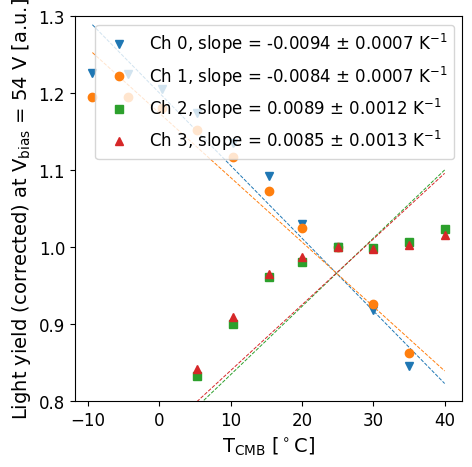

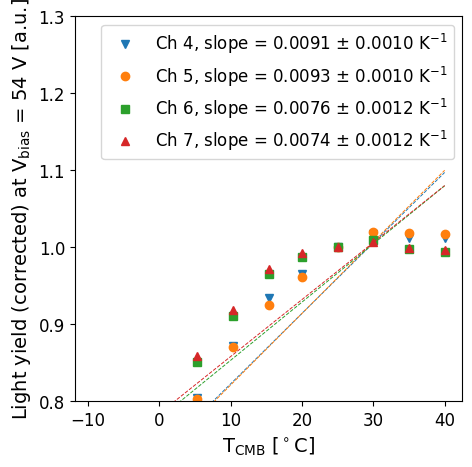

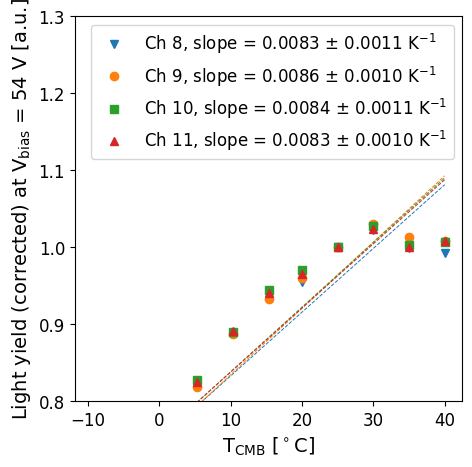

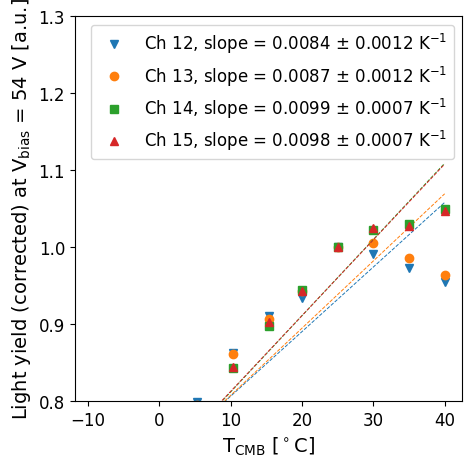

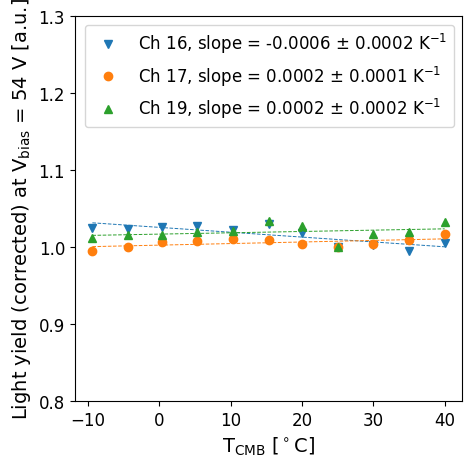

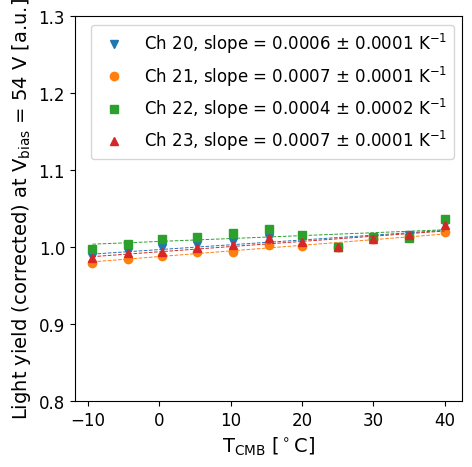

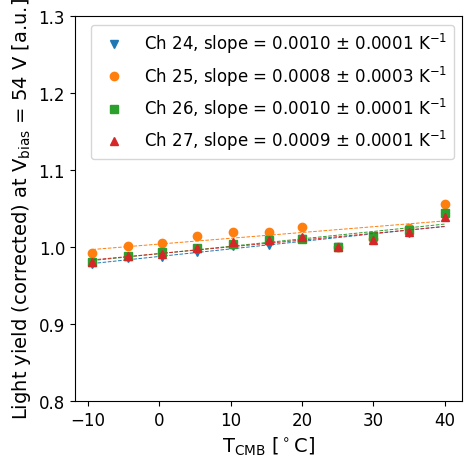

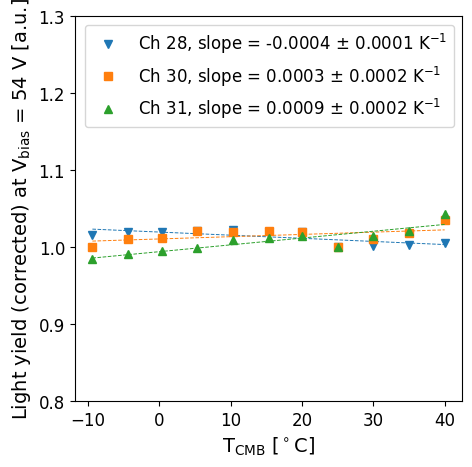

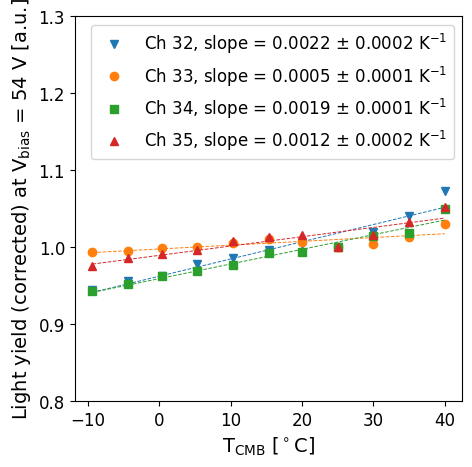

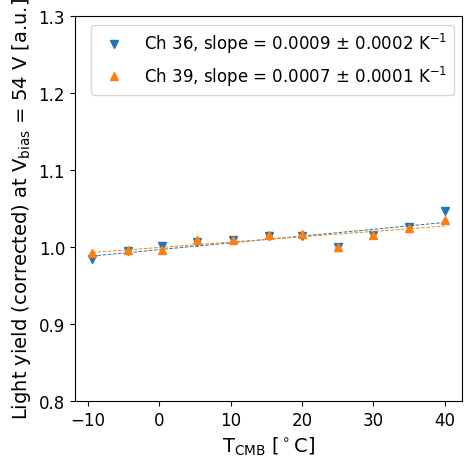

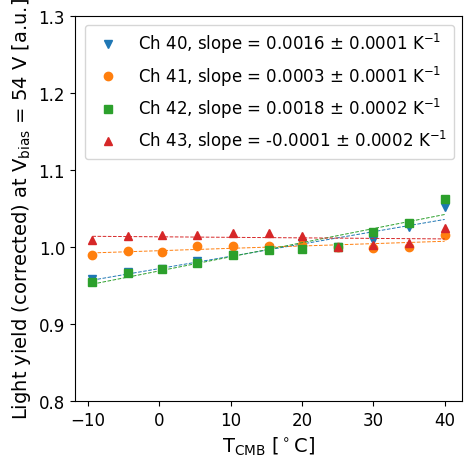

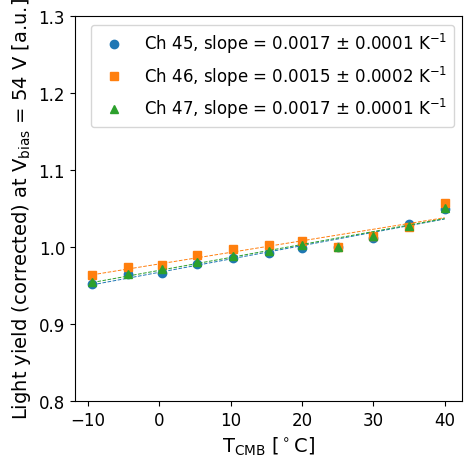

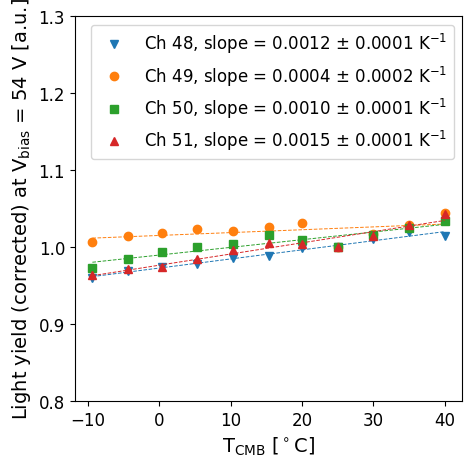

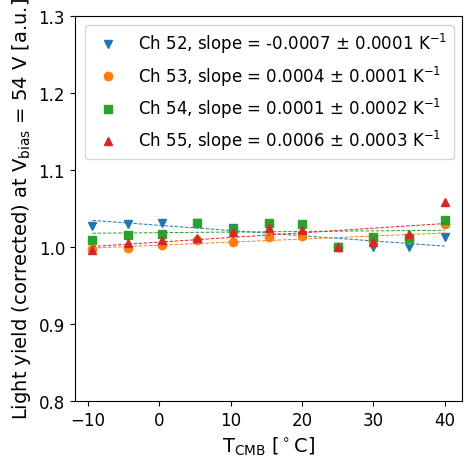

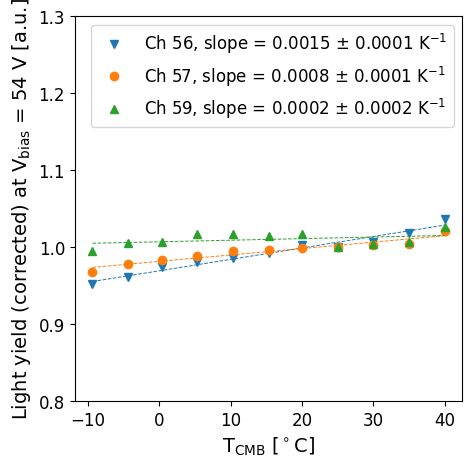

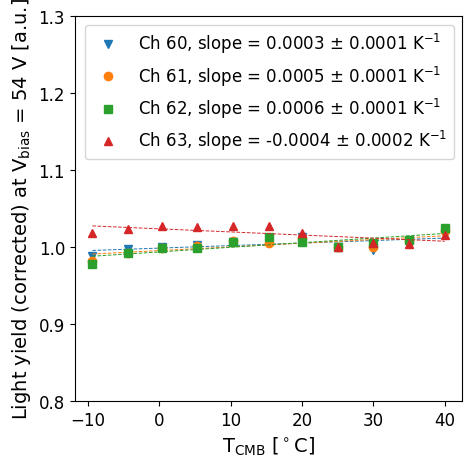

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages(os.path.join(analysis_dir,"PE_corr_sidet_run_1_008.pdf"))

for i in range(16):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlabel('T$_{\mathrm{CMB}}$ [$^\circ\mathrm{C}$]')
    ax.set_ylabel('Light yield (corrected) at V$_{\mathrm{bias}}$ = 54 V [a.u.]')
    start_chan = 4*i
    for chan in range(4):
        if chan+start_chan in bad_channels:
            continue
        df_ = df_008_PE.query("chan==%i"%(chan+start_chan)).reset_index()
        x = df_['tempSensor']
        y = df_['pe_54V_fix_adj'].to_numpy()
        y = y/y[7]
        print(chan+start_chan, y)
                   
        mask1 = ~np.isnan(y)
        mask2 = (y!=0)
        mask = mask1 & mask2
        x=x[mask]
        y=y[mask]
    
        popt, pcov = curve_fit(lin_func, x.astype(float), y.astype(float))
        slope = popt[0]
        intercept = popt[1]
        std_err = np.sqrt(pcov[0,0])
        intercept_stderr = np.sqrt(pcov[1,1])
        
        scatter = ax.plot(x, y, markers[chan], label='Ch %i, slope = %.4f $\pm$ %.4f K$^{-1}$'%(chan+start_chan, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = scatter[0].get_color(), linewidth=0.7)
        ax.set_ylim([0.8, 1.3])
        ax.legend()

    pp.savefig()
    
pp.close()